# Wearable Stress and Affect Detection (WESAD) Exploratory Data Analysis

## Part 2: Wrist Data Analysis

### [UCI Link](https://archive.ics.uci.edu/ml/datasets/WESAD+%28Wearable+Stress+and+Affect+Detection%29#)

'''
Philip Schmidt, Attila Reiss, Robert Duerichen, Claus Marberger and Kristof Van Laerhoven. 2018. 
Introducing WESAD, a multimodal dataset for Wearable Stress and Affect Detection. 
In 2018 International Conference on Multimodal Interaction (ICMI '18), October 16-20, 2018, Boulder, CO, USA. ACM, New York, NY, USA, 9 pages.
'''

This dataset is part of the UCI ML Data repository and contains high granularity data (700 Hz) of 15 test subjects from chest worn sensors (RespiBAN) in the form of:
  - Electrocardiography (ECG)
  - Electrodermal Activity (EDA)
  - Electromyography (EMG)
  - Body Temp (Temp)
  - Accelorometer (ACC)
  - Respiration % (Resp)
  
Contains data at lower granularity from wrist worn (non dominant) Empatica device in the form of:
  - Accelorometer (ACC)
  - BVP
  - Electrodermal Activity (EDA)
  - Body Temp (Temp)

Wearable data generation has exploded in recent years, and with it the analysis of it. Time series data can yield very interesting insights and can paint a picture of people's health that they would not be able to see themselves.

Let's explore this data and see what we find. **This notebook is part 2 for analyzing the wrist data above (Accelermeter, BVP, Electrodermal activity, body temperature); part 1 is for the chest data above. Will make a part three to compare wrist and chest data.**

## Import Packages and Configure Settings

In [1]:
# Do this first so we can have plots in the cells
%matplotlib inline
import matplotlib
#matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import glob
import os
import pickle

In [2]:
plt.style.available

['Solarize_Light2',
 '_classic_test_patch',
 'bmh',
 'classic',
 'dark_background',
 'fast',
 'fivethirtyeight',
 'ggplot',
 'grayscale',
 'seaborn',
 'seaborn-bright',
 'seaborn-colorblind',
 'seaborn-dark',
 'seaborn-dark-palette',
 'seaborn-darkgrid',
 'seaborn-deep',
 'seaborn-muted',
 'seaborn-notebook',
 'seaborn-paper',
 'seaborn-pastel',
 'seaborn-poster',
 'seaborn-talk',
 'seaborn-ticks',
 'seaborn-white',
 'seaborn-whitegrid',
 'tableau-colorblind10']

In [3]:
plt.style.use('ggplot')

In [4]:
# Before we start, let's fix the row/column displays so we can see all rows/columns
# Set ipython's max row display
pd.set_option('display.max_row', 100)

# Set iPython's max column width to 50
pd.set_option('display.max_columns', 100)

# Also for numpy, since we will be creating arrays off of the data
import numpy as np
import sys
np.set_printoptions(threshold=sys.maxsize)

# Suppress scientific notation, show as decimals
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Do this to have jupyter notebook displayed in FULL
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

## Preprocess & Clean Data

It's both exciting and exhausting to explore a data set without any context or guidance on how it should look/what issues may need to be accounted for. There's so many different possibilities that can be explored, but since no one has unlimited time on their hands one must always be diligent on how much time in spent in data cleaning + exploration.

Luckily for this dataset, the expected data format was already included with the data (and it is relatively easy to determine when exploring). I will still output some quick items for inspection like the df shape, columns and head. Let's go ahead and parse all the pickle files and create a subject dictionary of subject id-dataframe pairs.

In [5]:
# This is from the data_etl.py script
# Posting the format of the data below from the wesad_readme.pdf
"""
According to the README:
The double-tap signal pattern was used to manually synchronise the two devices' raw data. The result is provided in the files SX.pkl, one file per subject. This file is a dictionary, with the following keys:
- 'subject': SX, the subject ID
- 'signal': includes all the raw data, in two fields:
  - 'chest': RespiBAN data (all the modalities: ACC, ECG, EDA, EMG, RESP, TEMP)
  - 'wrist':EmpaticaE4data(all the modalities:ACC,BVP,EDA,TEMP)
- 'label': ID of the respective study protocol condition, sampled at 700 Hz. The following IDs
are provided: 0 = not defined / transient, 1 = baseline, 2 = stress, 3 = amusement, 4 = meditation, 5/6/7 = should be ignored in this dataset
"""

# Study protocal conditions (label) mapping
label_map = {
    0: 'not defined / transient',
    1: 'baseline',
    2: 'stress',
    3: 'amusement',
    4: 'meditation',
}


# Read in WESAD datasets by subject and unpickle
subject_dct = {}
path = '../../data/WESAD'
filenames = glob.glob(os.path.join(path,'*/*.pkl'))
for file in filenames:
    
    # Had to use 'latin1' as the encoding due to Python 2/3 pickle incompatibility
    # https://stackoverflow.com/questions/11305790/pickle-incompatibility-of-numpy-arrays-between-python-2-and-3
    unpickled_file = pickle.load(open(file,'rb'), encoding='latin1')
    # Grab relevant info
    subject_id = unpickled_file['subject']
    print('processing subject',subject_id)
    # Grab chest and wrist dataframes
    chest_dct = unpickled_file['signal']['chest']
    wrist_dct = unpickled_file['signal']['wrist']

    # Process the chest dictionary first as it is more straight forward
    # Since the 'ACC' column contains 3 dimensional tuples, it needs to be processed separately due to pandas expecting the same format for all columns
    # Going to create dictionaries without that column to turn into a dataframe, then add the 'ACC' values later
    tmp_chest_dct = dict((k, chest_dct[k].ravel()) for k in list(chest_dct.keys()) if k not in ['ACC'])
    tmp_chest_df = pd.DataFrame(tmp_chest_dct) # Contains everything except ACC
    tmp_acc_df = pd.DataFrame(chest_dct['ACC'],columns=['ACC_X','ACC_Y','ACC_Z']) # Manually declare keys, otherwise shows up as 0,1,2
    final_chest_df = pd.concat([tmp_chest_df,tmp_acc_df],axis=1)

    # Process wrist dictionary, which will take more care because the samplying frequencies were different 
    # Meaning the number of data points collected for each feature is different (higher frequency equals more data points)
    # Basically this one just needs to be processed manually
    wrist_acc_df = pd.DataFrame(wrist_dct['ACC'],columns=['ACC_X','ACC_Y','ACC_Z'])
    wrist_bvp_df = pd.DataFrame(wrist_dct['BVP'],columns=['BVP'])
    wrist_eda_df = pd.DataFrame(wrist_dct['EDA'],columns=['EDA'])
    wrist_temp_df = pd.DataFrame(wrist_dct['TEMP'],columns=['TEMP'])

    # Add labels as a separate object to be returned
    # While the time granularity is the same as the chest data, I'm not sure yet how to use it with the wrist data
    # So will just keep it separate and add as needed
    labels_df = pd.DataFrame(unpickled_file['label'],columns=['label'])
    labels_df['mapped_label'] = labels_df['label'].map(label_map)
    labels_df['SUBJECT_ID'] = subject_id
    
    # Add subject id to all dataframes
    for df in [final_chest_df, wrist_acc_df, wrist_bvp_df, wrist_eda_df, wrist_temp_df]:
        df['SUBJECT_ID'] = subject_id

    subject_dct[subject_id] = {
        'chest_df': final_chest_df,
        'wrist_dfs': {
            'wrist_acc_df': wrist_acc_df,
            'wrist_bvp_df': wrist_bvp_df,
            'wrist_eda_df': wrist_eda_df,
            'wrist_temp_df': wrist_temp_df,
        },
        'labels': labels_df,
    }

processing subject S5
processing subject S2
processing subject S3
processing subject S4
processing subject S17
processing subject S10
processing subject S11
processing subject S16
processing subject S8
processing subject S6
processing subject S7
processing subject S9
processing subject S13
processing subject S14
processing subject S15


# Quick Inspection of Data

Since we are working with wearables data it is reasonable to assume that the data we will be working with is largely continuous, with the labels being the one obvious discrete variable (which will require some additional analysis to inspect the distribution of that feature). 

For a randomly selected dataframe let's check out:
 - The shape of the data (number of rows and columns)
 - .The head (i.e. first n rows) of the dataset to get some example values
 - The different columns in the dataset
  
Later on we will plot out our data to see how it varies over time. Since this was an experiment I am predicting we will see spikes in certain measurements related to heart/respiratory rate during experiments designed to elicit emotional responses.

In [6]:
def quick_inspect(df):
    # Print out some quick items for our view
    print(df.shape)
    print(df.columns)
    display(df.head(10))

In [7]:
# Pick random subject to inspect
# According to the docs, Subject 1 and 12 had device malfunctions so their data was discarded
# So we will pick something between 2 and 17 and add logic to choose another number if 12 is chosen
from random import randint
removed_subjects = [12]
valid_choice = False
while not valid_choice:
    rand = randint(2,17)
    if rand not in removed_subjects:
        valid_choice = True
    else:
        print('Subject 12 chosen, choosing again')
rand_string = 'S' + str(rand)
print(rand_string)

S10


In [31]:
pd.concat([subject_dct[rand_string]['wrist_dfs'][key].drop(columns=['SUBJECT_ID']) for key in list(subject_dct[rand_string]['wrist_dfs'].keys())],axis=1)

,ACC_X,ACC_Y,ACC_Z,BVP,EDA,TEMP
0,107.000,-105.000,127.000,10.170,0.349,33.130
1,67.000,-52.000,45.000,12.040,0.347,33.160
2,26.000,40.000,0.000,13.010,0.350,33.160
3,52.000,12.000,46.000,13.070,0.336,33.160
4,42.000,20.000,45.000,12.330,0.339,33.160
...,...,...,...,...,...,...
351739,nan,nan,nan,28.010,nan,nan
351740,nan,nan,nan,44.410,nan,nan
351741,nan,nan,nan,57.590,nan,nan
351742,nan,nan,nan,65.930,nan,nan


In [8]:
# Wrist dfs
## ACC
quick_inspect(subject_dct[rand_string]['wrist_dfs']['wrist_acc_df'])

(175872, 4)
Index(['ACC_X', 'ACC_Y', 'ACC_Z', 'SUBJECT_ID'], dtype='object')


,ACC_X,ACC_Y,ACC_Z,SUBJECT_ID
0,107.000,-105.000,127.000,S10
1,67.000,-52.000,45.000,S10
2,26.000,40.000,0.000,S10
3,52.000,12.000,46.000,S10
4,42.000,20.000,45.000,S10
5,24.000,33.000,-6.000,S10
6,2.000,45.000,-31.000,S10
7,13.000,40.000,-69.000,S10
8,26.000,13.000,-35.000,S10
9,127.000,-103.000,127.000,S10


In [9]:
## BVP
quick_inspect(subject_dct[rand_string]['wrist_dfs']['wrist_bvp_df'])

(351744, 2)
Index(['BVP', 'SUBJECT_ID'], dtype='object')


,BVP,SUBJECT_ID
0,10.170,S10
1,12.040,S10
2,13.010,S10
3,13.070,S10
4,12.330,S10
5,10.990,S10
6,9.380,S10
7,7.820,S10
8,6.610,S10
9,5.910,S10


In [10]:
## EDA
quick_inspect(subject_dct[rand_string]['wrist_dfs']['wrist_eda_df'])

(21984, 2)
Index(['EDA', 'SUBJECT_ID'], dtype='object')


,EDA,SUBJECT_ID
0,0.349,S10
1,0.347,S10
2,0.350,S10
3,0.336,S10
4,0.339,S10
5,0.336,S10
6,0.340,S10
7,0.331,S10
8,0.336,S10
9,0.334,S10


In [11]:
## Temperature
quick_inspect(subject_dct[rand_string]['wrist_dfs']['wrist_temp_df'])

(21984, 2)
Index(['TEMP', 'SUBJECT_ID'], dtype='object')


,TEMP,SUBJECT_ID
0,33.130,S10
1,33.160,S10
2,33.160,S10
3,33.160,S10
4,33.160,S10
5,33.150,S10
6,33.150,S10
7,33.150,S10
8,33.150,S10
9,33.160,S10


# Analyzing the Distributions of our Data

The built in describe() method in Pandas dataframes is a great way to get an initial idea of the distributions of the numeric features in your data. It outputs a standard 5 point summary (min, 25th percentile, median, 75th percentile, and max) as well as non-null data count, mean and standard deviation. We can use this to quickly determine things like: 
  - To what extent the data is skewed or not by comparing the mean to the median (or 50th percentile)
  - Looking at the other percentiles (25%, 75%) to get an idea of the extent the data is skewed in either direction

For this part I will combine all data and describe it in aggregate; we will lose information this way because we are removing the time series element as well as separation by subject. We will revisit this below.

Let's give it a go!

In [12]:
subject_ids = list(subject_dct.keys())
display(subject_ids)

['S5',
 'S2',
 'S3',
 'S4',
 'S17',
 'S10',
 'S11',
 'S16',
 'S8',
 'S6',
 'S7',
 'S9',
 'S13',
 'S14',
 'S15']

### Wrist Data 

Each type of data needs to be done separately due to different data granularities

In [13]:
# See what keys are in the wrist_df
subject_dct['S5']['wrist_dfs'].keys()

dict_keys(['wrist_acc_df', 'wrist_bvp_df', 'wrist_eda_df', 'wrist_temp_df'])

In [14]:
# Combine all data together and describe
all_subjects_wrist_acc_df = pd.concat([subject_dct[subject_id]['wrist_dfs']['wrist_acc_df'] for subject_id in list(subject_dct.keys())],axis=0)
all_subjects_wrist_bvp_df = pd.concat([subject_dct[subject_id]['wrist_dfs']['wrist_bvp_df'] for subject_id in list(subject_dct.keys())],axis=0)
all_subjects_wrist_eda_df = pd.concat([subject_dct[subject_id]['wrist_dfs']['wrist_eda_df'] for subject_id in list(subject_dct.keys())],axis=0)
all_subjects_wrist_temp_df = pd.concat([subject_dct[subject_id]['wrist_dfs']['wrist_temp_df'] for subject_id in list(subject_dct.keys())],axis=0)

In [15]:
pd.concat([df.describe().apply(lambda s: s.apply(lambda x: format(x, 'f'))) for df in [all_subjects_wrist_acc_df,all_subjects_wrist_bvp_df,all_subjects_wrist_eda_df,all_subjects_wrist_temp_df]],axis=1)

,ACC_X,ACC_Y,ACC_Z,BVP,EDA,TEMP
count,2779776.000000,2779776.000000,2779776.000000,5559552.000000,347472.000000,347472.000000
mean,11.654745,-2.275712,17.708996,0.001968,1.801780,32.598085
std,44.107348,28.142362,29.746571,65.166243,2.343278,1.498091
min,-128.000000,-128.000000,-128.000000,-1773.760000,0.045113,28.970000
25%,-36.000000,-19.000000,-2.000000,-14.930000,0.335976,31.550000
50%,26.000000,-1.000000,17.000000,2.120000,0.830669,32.710000
75%,51.000000,12.000000,43.000000,16.220000,2.396028,33.680000
max,127.000000,127.000000,127.000000,1789.000000,15.921474,35.970000


# A Closer Look

## Histograms
If we really want to see how the values of a given feature are spread out and concentrated, we should plot the counts of each unique data point in each feature set.

This way we can separately get a list of counts and analyze it by itself, as well as not have to create a ton of variables storing unique value counts of various features.

**Note: This is a great starting point to analyze numerical categorical data (i.e. labels). Histogram of labels will be included for comparison**

**Another note: We are ignoring the time element here, so any observations here should be taken with a grain of salt**

In [16]:
'''
# Reposting study protocal conditions (label) mapping for reference
label_map = {
    0: 'not defined / transient',
    1: 'baseline',
    2: 'stress',
    3: 'amusement',
    4: 'meditation',
}
'''

"\n# Reposting study protocal conditions (label) mapping for reference\nlabel_map = {\n    0: 'not defined / transient',\n    1: 'baseline',\n    2: 'stress',\n    3: 'amusement',\n    4: 'meditation',\n}\n"

<AxesSubplot:title={'center':'TEMP'}>

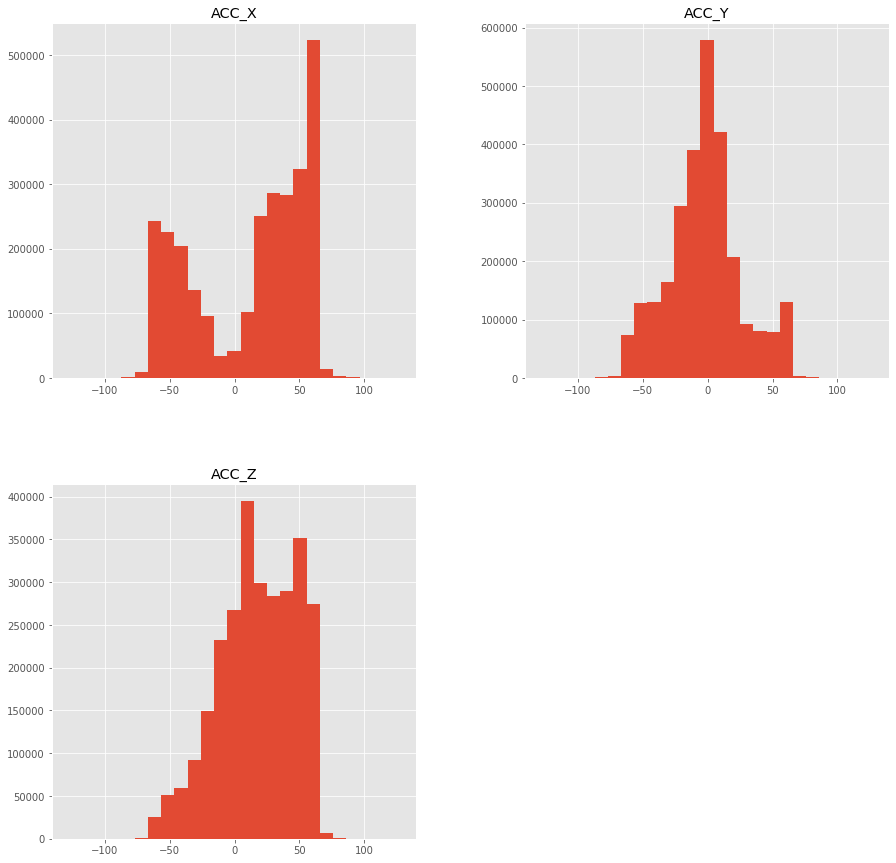

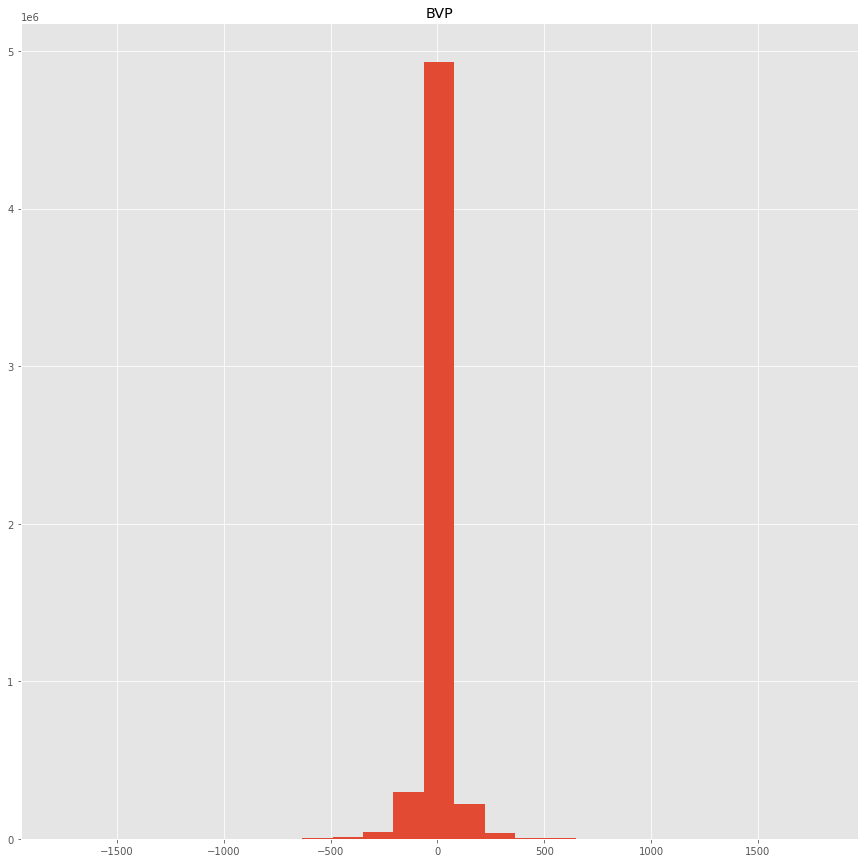

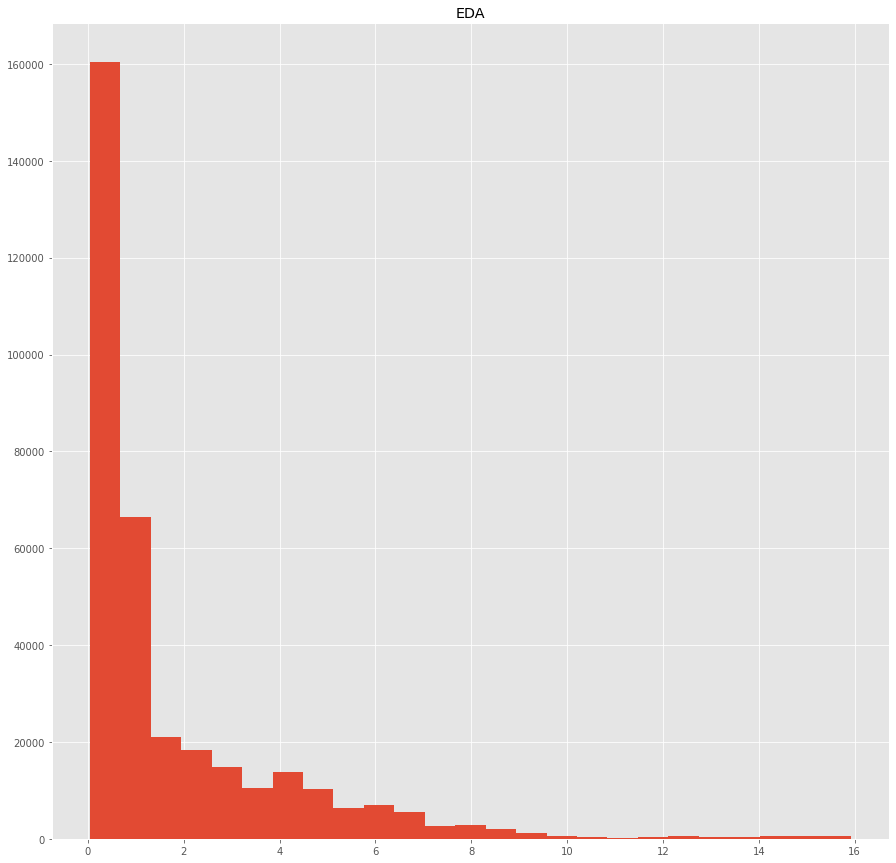

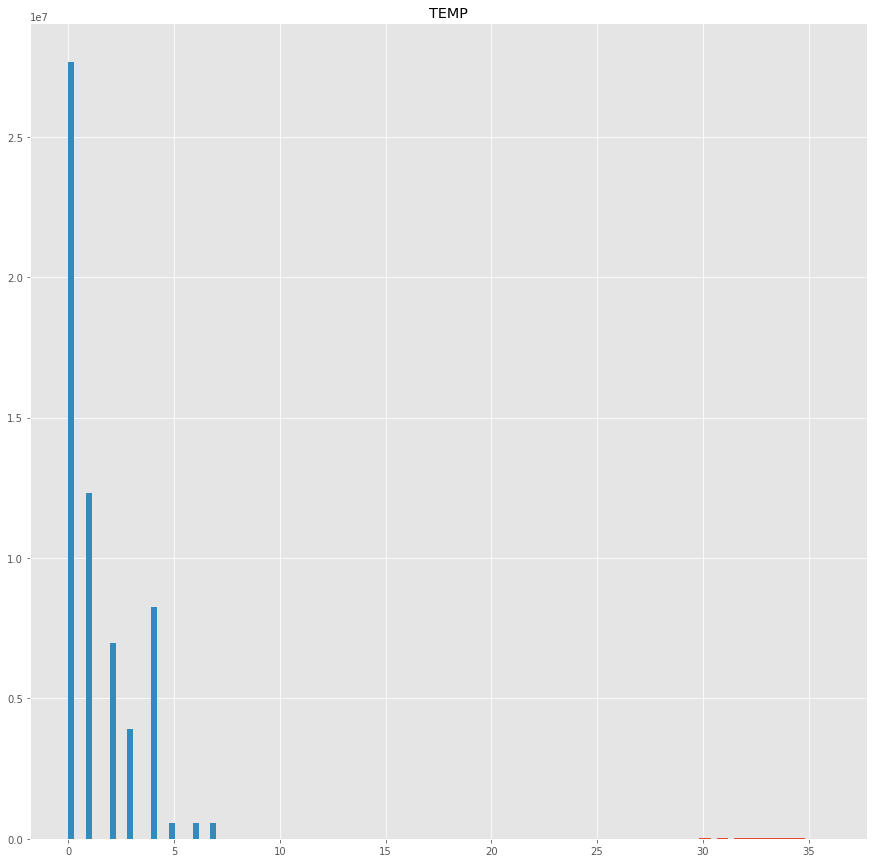

In [17]:
all_subjects_wrist_acc_df.hist(figsize=(15,15),bins=25)
all_subjects_wrist_bvp_df.hist(figsize=(15,15),bins=25)
all_subjects_wrist_eda_df.hist(figsize=(15,15),bins=25)
all_subjects_wrist_temp_df.hist(figsize=(15,15),bins=25)
pd.concat([subject_dct[subject_id]['labels']['label'] for subject_id in subject_ids]).hist(figsize=(15,15),bins=25)

# Some Observations on the Sensor Data

Including labels here because we are interested in how well the wrist sensor was able to pick up expected changes in data

- Labels:
  - Order of class by decreasing frequency as follows  (5,6, and 7 should be ignored):
    1. 'not defined/transient'
    2. 'baseline'
    3. 'meditation'
    4. 'stress', 
    5. 'amusement'
  - This is mostly as expected, but looks like the state of meditation is quite frequent so that is worth a closer look
  
## Wrist Data
 
- Accelerometer (ACC):
  - Quite a bit of variation here, likely attributable to being on the wrist and being more prone to large changes in position
      - Worth pointing out that the X direction data is concentrated at the ends while the Y & Z direction data is more normally distributed
        - To me, this means alot of movement was done in one set of directions (i.e. north to south, east to west, etc.)
- BVP (measures from PPG):
  - High overall range of values but graph shows a fairly normal distribution, so min and max values are likely outliers
  - Don't have enough info on this data type to make any more meaningful conclusions
- Electrodermal Activity (EDA): 
  - We see good variation here but less than what would be expected based on the label data
    - This is likely due to the fact that the wrist worn sensor is less sensitive and won't pick up smaller changes in electrical activity on the skin
- Body Temperature:
  - Healthy variation here and largely normally distributed, but still largely a tight range of numbers

# Some of my overall assumptions based on what's we've seen so far

Based on the above observations let's make a couple assumptions about the data and use other methods to try and prove them wrong:
1. Most of the high respitory rate data occurred during a specific range of values (i.e. during a specific stress experiment).
2. Higher EDA values correlate highly (?) to labels of 'stress' and 'amusement' (and lower correspond to 'meditation' and 'baseline').
3. Most of the changes to the accelerometer data occur during a specific range of values (moving to different areas for experiments)
4. The EDA wrist and EDA chest data are highly correlated per subject (all above 0.5)

# Now let's prove them wrong!!

## Plot Data Directly

In order to get the complete picture and test out the above assumptions, we should plot the data in order to see how it varies across the time period of the experiment. In order to be able to compare each subjects's data in the most intuitive way we will plot all subject data onto one graph. This will allow us to validate or discard some of the early conclusions made above.

**Note: We can do this because we have a limited number of actual subjects in the data; if there were hundreds it wouldn't be practical to graph each subject's data on one graph (instead it would be more appropriate to graph summary statistics)**

## Wrist Data

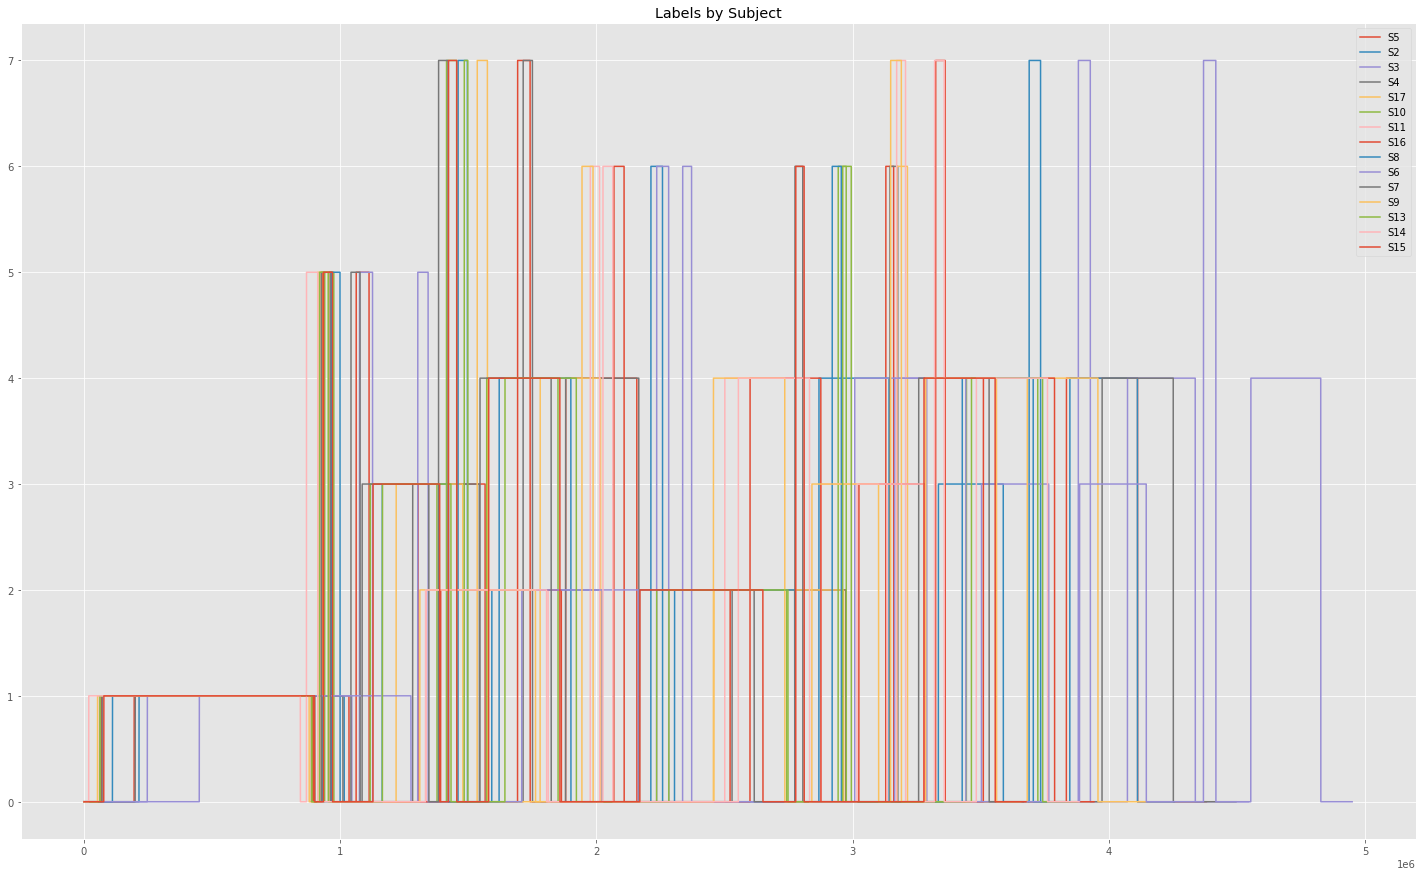

In [18]:
fig, ax = plt.subplots()
for subject in subject_ids:
    subject_dct[subject]['labels']['label'].plot(figsize = (25,15))

ax.legend(subject_ids)
ax.set_title('Labels by Subject')
plt.show()

/Users/nfritter/workspace/fitbit/data-science/gitRepos/Characteristic-Based-Time-Series-Clustering/venv/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


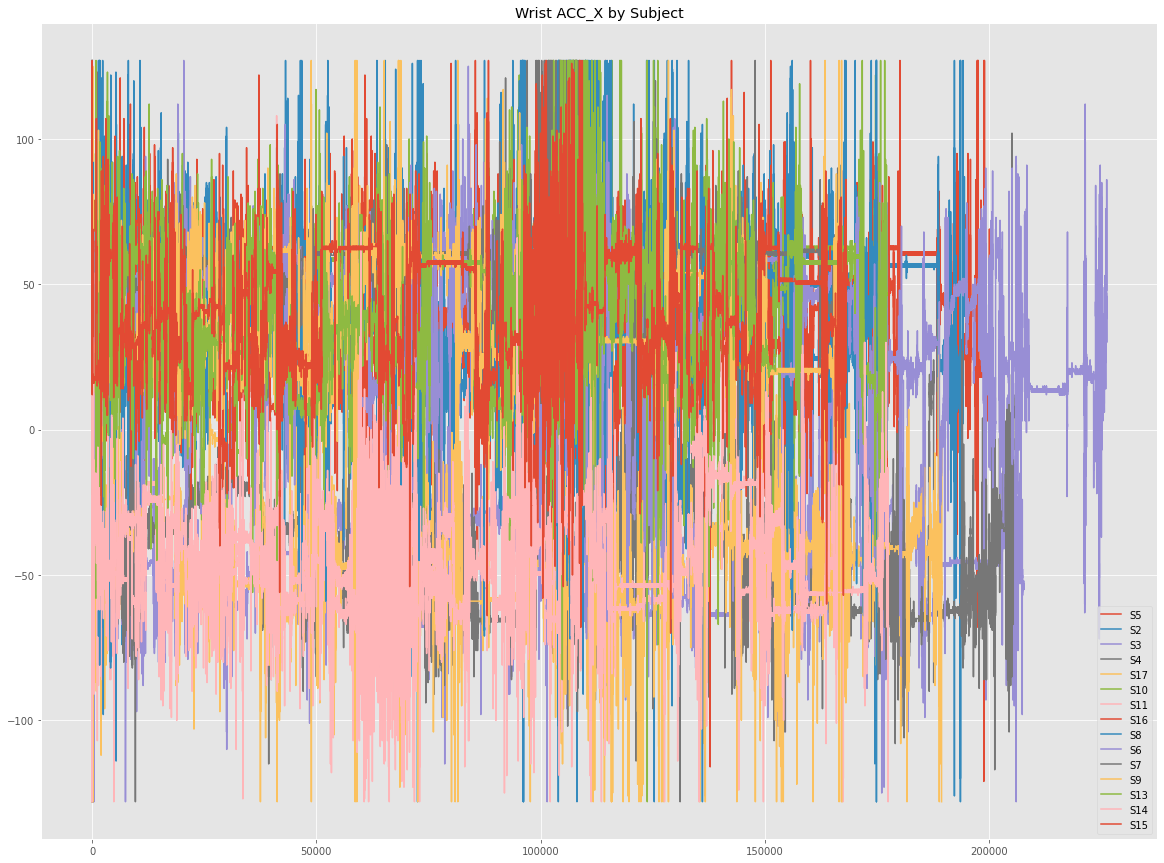

In [19]:
# ACC_X
wrist_keys = list(subject_dct[subject]['wrist_dfs'].keys())
fig, ax = plt.subplots()
for subject in subject_ids:
    subject_dct[subject]['wrist_dfs'][wrist_keys[0]]['ACC_X'].plot(figsize = (20,15))

ax.legend(subject_ids)
ax.set_title('Wrist ACC_X by Subject')
plt.show()

/Users/nfritter/workspace/fitbit/data-science/gitRepos/Characteristic-Based-Time-Series-Clustering/venv/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


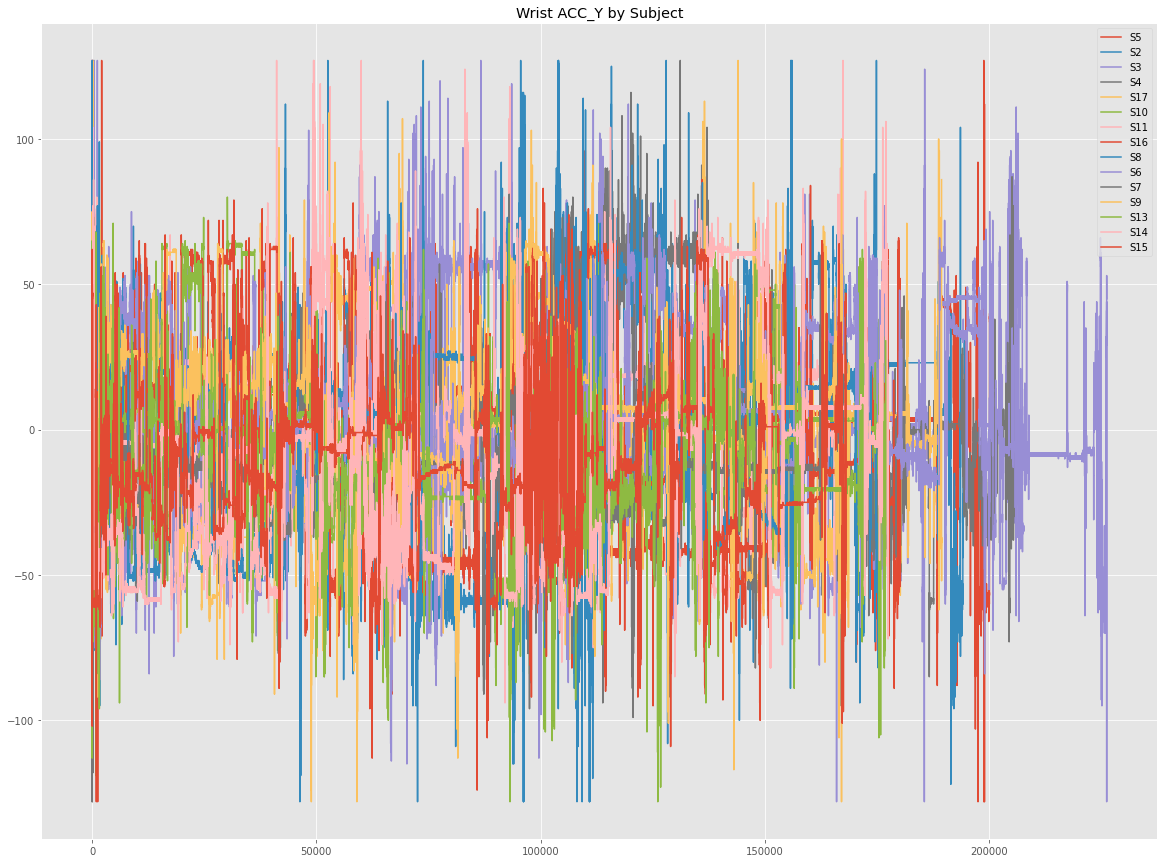

In [20]:
# ACC_Y
fig, ax = plt.subplots()
for subject in subject_ids:
    subject_dct[subject]['wrist_dfs'][wrist_keys[0]]['ACC_Y'].plot(figsize = (20,15))

ax.legend(subject_ids)
ax.set_title('Wrist ACC_Y by Subject')
plt.show()

/Users/nfritter/workspace/fitbit/data-science/gitRepos/Characteristic-Based-Time-Series-Clustering/venv/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


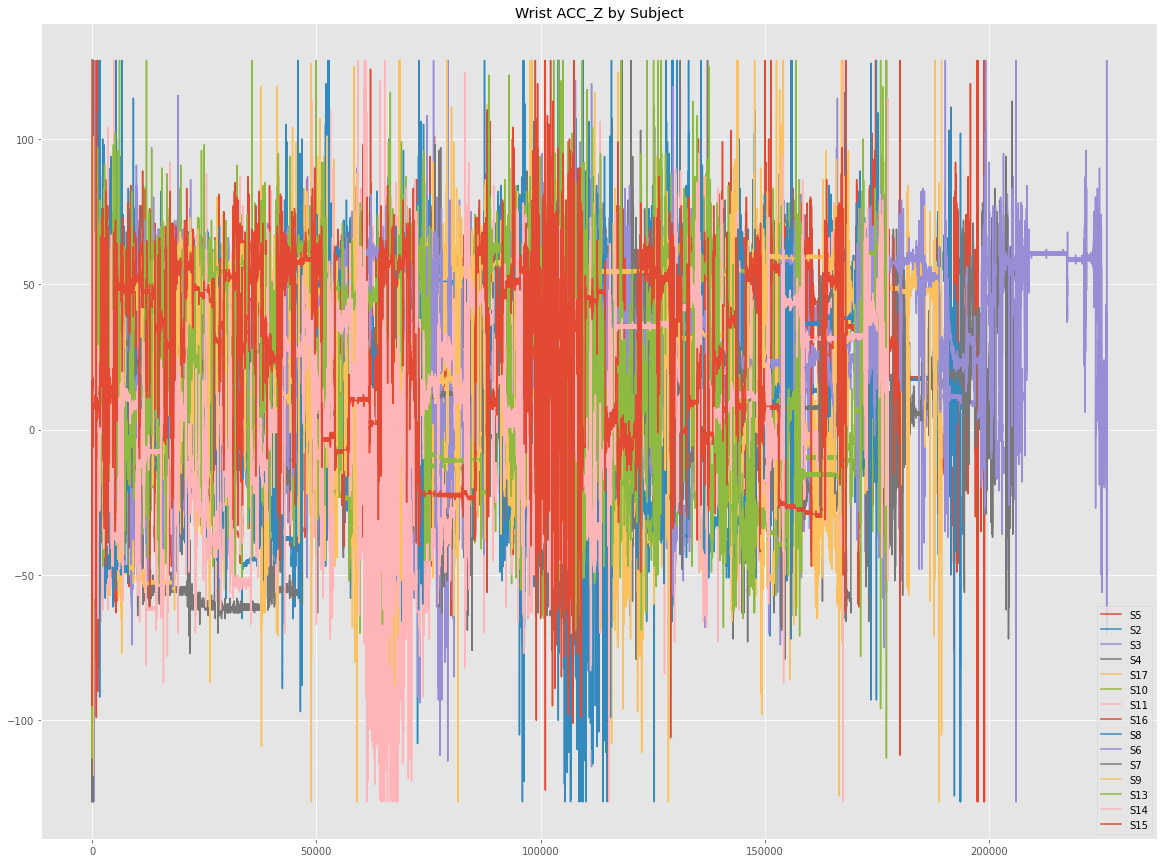

In [21]:
# ACC_Z
fig, ax = plt.subplots()
for subject in subject_ids:
    subject_dct[subject]['wrist_dfs'][wrist_keys[0]]['ACC_Z'].plot(figsize = (20,15))

ax.legend(subject_ids)
ax.set_title('Wrist ACC_Z by Subject')
plt.show()

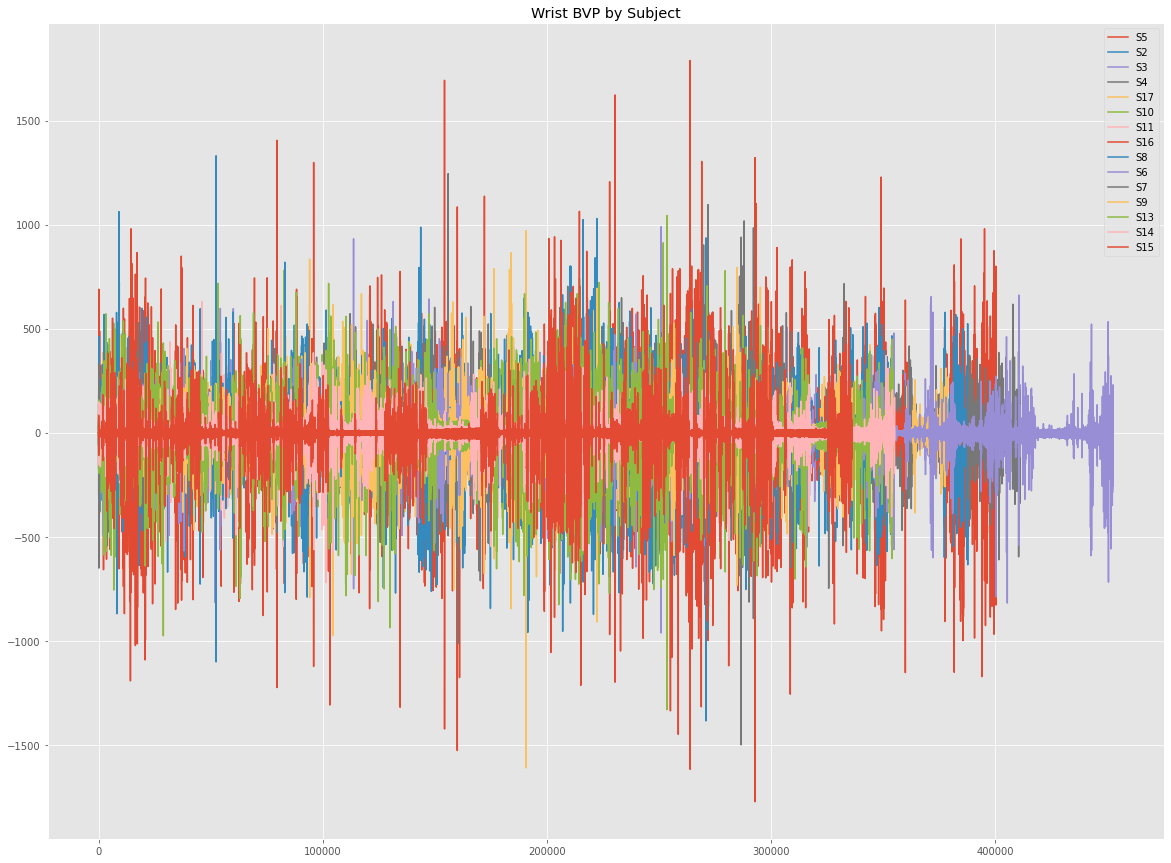

In [22]:
# BVP
fig, ax = plt.subplots()
for subject in subject_ids:
    subject_dct[subject]['wrist_dfs'][wrist_keys[1]]['BVP'].plot(figsize = (20,15))

ax.legend(subject_ids)
ax.set_title('Wrist BVP by Subject')
plt.show()

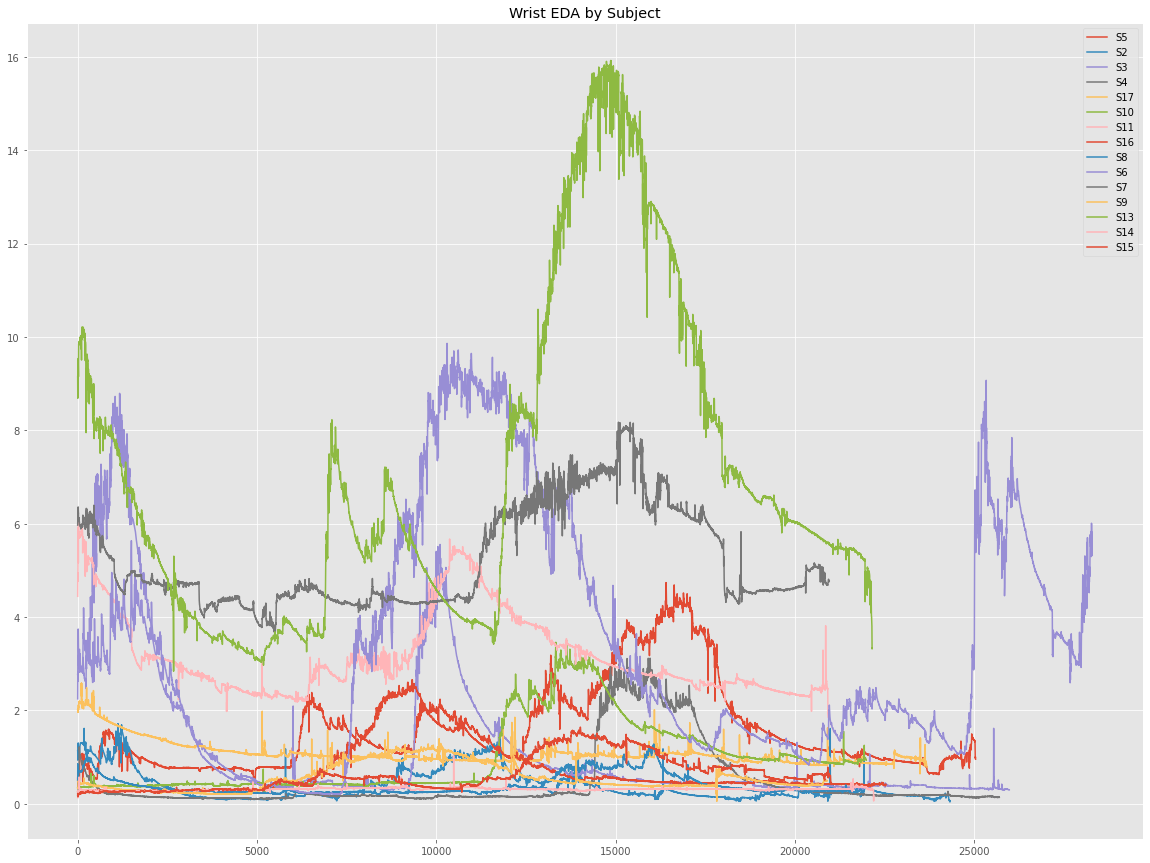

In [23]:
# EDA
fig, ax = plt.subplots()
for subject in subject_ids:
    subject_dct[subject]['wrist_dfs'][wrist_keys[2]]['EDA'].plot(figsize = (20,15))

ax.legend(subject_ids)
ax.set_title('Wrist EDA by Subject')
plt.show()

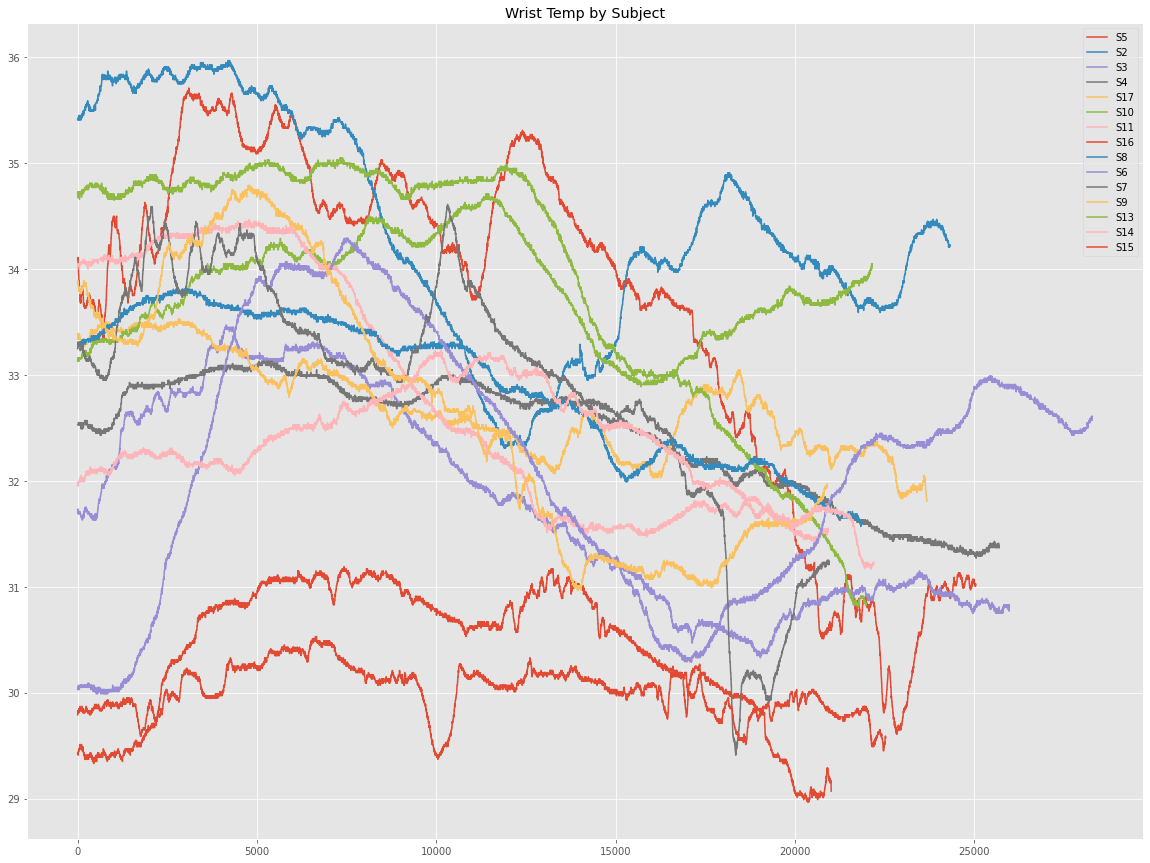

In [24]:
# Temp
fig, ax = plt.subplots()
for subject in subject_ids:
    subject_dct[subject]['wrist_dfs'][wrist_keys[3]]['TEMP'].drop(columns='SUBJECT_ID').plot(figsize = (20,15))

ax.legend(subject_ids)
ax.set_title('Wrist Temp by Subject')
plt.show()

The labels, accelerometer and BVP data are quite dense, so they might need some more in depth analysis (or at the very least an aggregation every minute or so to reduce the density of the data so the graphs will render better).

Wrist temp and EDA seemed to be quite all over the place. From EDA, it **seems** like there could be some stress incuding experiments occuring between time point 10000 and 15000 but it doesn't appear consistent to all subjects. This jives with Wrist temp a bit, but it's still largely inconsistent.

# Scatter Plots

While the above descriptive statistics are helpful, it may be less clear how features with similar measures (mean, median, standard deviation, etc.) relate to each other (if at all). We should graph these features against each other and see how they relate to each other (negatively/positively, strong/weak, etc.). 

If we end up deciding to try and create a model later, this analysis will help us decide what variables to use and remove.

For this, we will import another visualization packages (seaborn) that has some nicer plotting features and functionalities.

## Wrist Data

In [25]:
# Import package and plot correlation
import seaborn as sns
# From https://towardsdatascience.com/better-heatmaps-and-correlation-matrix-plots-in-python-41445d0f2bec
def plot_sns_heatmap(corr):
    plt.figure(figsize=(14,14))
    ax = sns.heatmap(
        corr, 
        vmin=-1, vmax=1, center=0,
        cmap=sns.diverging_palette(220, 20, n=200),
        square=True,
        annot=True
    )
    ax.set_xticklabels(
        ax.get_xticklabels(),
        rotation=45,
        horizontalalignment='right'
    );

## Correlation Between Wrist Data and Labels

In [32]:
# Look at correlations by subject
corr_dct = {}
combined_dct = {}
for subject in subject_ids: 
    subject_df = pd.concat([subject_dct[subject]['wrist_dfs'][key].drop(columns=['SUBJECT_ID']) for key in list(subject_dct[subject]['wrist_dfs'].keys())],axis=1)
    labels = subject_dct[subject]['labels']['label']
    df = pd.concat([subject_df,labels],axis=1)
    corr_dct[subject] = df.corr()
display(corr_dct)

{'S5':        ACC_X  ACC_Y  ACC_Z    BVP    EDA   TEMP  label
 ACC_X  1.000  0.139 -0.482  0.001 -0.107 -0.140 -0.113
 ACC_Y  0.139  1.000 -0.110  0.000 -0.198 -0.059 -0.113
 ACC_Z -0.482 -0.110  1.000 -0.000  0.348 -0.153  0.026
 BVP    0.001  0.000 -0.000  1.000  0.002 -0.000 -0.000
 EDA   -0.107 -0.198  0.348  0.002  1.000  0.089    nan
 TEMP  -0.140 -0.059 -0.153 -0.000  0.089  1.000    nan
 label -0.113 -0.113  0.026 -0.000    nan    nan  1.000,
 'S2':        ACC_X  ACC_Y  ACC_Z    BVP    EDA   TEMP  label
 ACC_X  1.000  0.301 -0.435  0.001 -0.371 -0.040    nan
 ACC_Y  0.301  1.000  0.052  0.001 -0.280 -0.479    nan
 ACC_Z -0.435  0.052  1.000  0.001 -0.024 -0.009    nan
 BVP    0.001  0.001  0.001  1.000 -0.000 -0.000 -0.000
 EDA   -0.371 -0.280 -0.024 -0.000  1.000 -0.216    nan
 TEMP  -0.040 -0.479 -0.009 -0.000 -0.216  1.000    nan
 label    nan    nan    nan -0.000    nan    nan  1.000,
 'S3':        ACC_X  ACC_Y  ACC_Z    BVP    EDA   TEMP  label
 ACC_X  1.000  0.127  0.374 

In [33]:
# Show one example of the correlation dictionary
display(corr_dct['S4'])

,ACC_X,ACC_Y,ACC_Z,BVP,EDA,TEMP,label
ACC_X,1.000,0.315,-0.180,-0.001,0.191,-0.690,0.047
ACC_Y,0.315,1.000,0.112,0.000,0.153,-0.289,-0.029
ACC_Z,-0.180,0.112,1.000,0.000,-0.324,0.634,0.161
BVP,-0.001,0.000,0.000,1.000,-0.001,0.000,0.000
EDA,0.191,0.153,-0.324,-0.001,1.000,-0.062,nan
TEMP,-0.690,-0.289,0.634,0.000,-0.062,1.000,nan
label,0.047,-0.029,0.161,0.000,nan,nan,1.000


<AxesSubplot:>

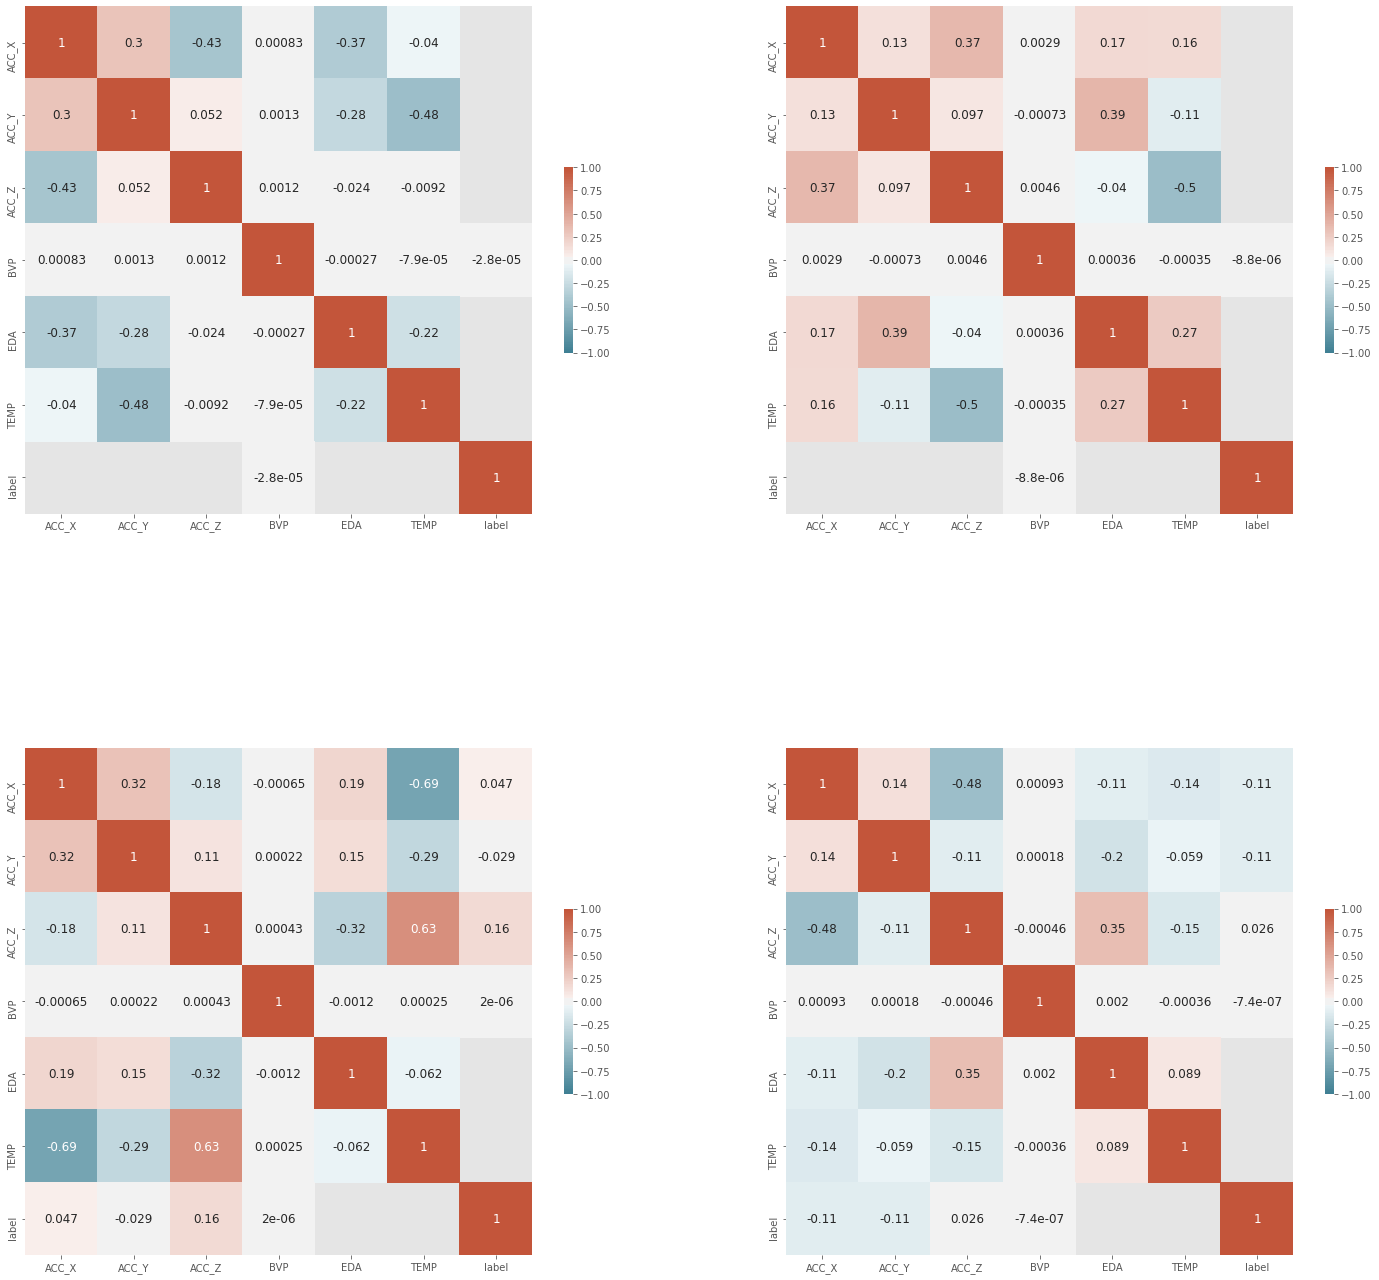

In [34]:
# Create a figure instance and 4 subplots
fig = plt.figure(figsize = (25,25)) # width x height
ax1 = fig.add_subplot(2, 2, 1) # row, column, position
ax2 = fig.add_subplot(2, 2, 2)
ax3 = fig.add_subplot(2, 2, 3)
ax4 = fig.add_subplot(2, 2, 4)

# Heatmap parameters
cmap = sns.diverging_palette(220, 20, n=200)
# We use ax parameter to tell seaborn which subplot to use for this plot
sns.heatmap(data=corr_dct['S2'], ax=ax1, cmap = cmap, vmin=-1, vmax=1, center=0, square=True, cbar_kws={'shrink': .3}, annot=True, annot_kws={'fontsize': 12})
sns.heatmap(data=corr_dct['S3'], ax=ax2, cmap = cmap, vmin=-1, vmax=1, center=0, square=True, cbar_kws={'shrink': .3}, annot=True, annot_kws={'fontsize': 12})
sns.heatmap(data=corr_dct['S4'], ax=ax3, cmap = cmap, vmin=-1, vmax=1, center=0, square=True, cbar_kws={'shrink': .3}, annot=True, annot_kws={'fontsize': 12})
sns.heatmap(data=corr_dct['S5'], ax=ax4, cmap = cmap, vmin=-1, vmax=1, center=0, square=True, cbar_kws={'shrink': .3}, annot=True, annot_kws={'fontsize': 12})

<AxesSubplot:>

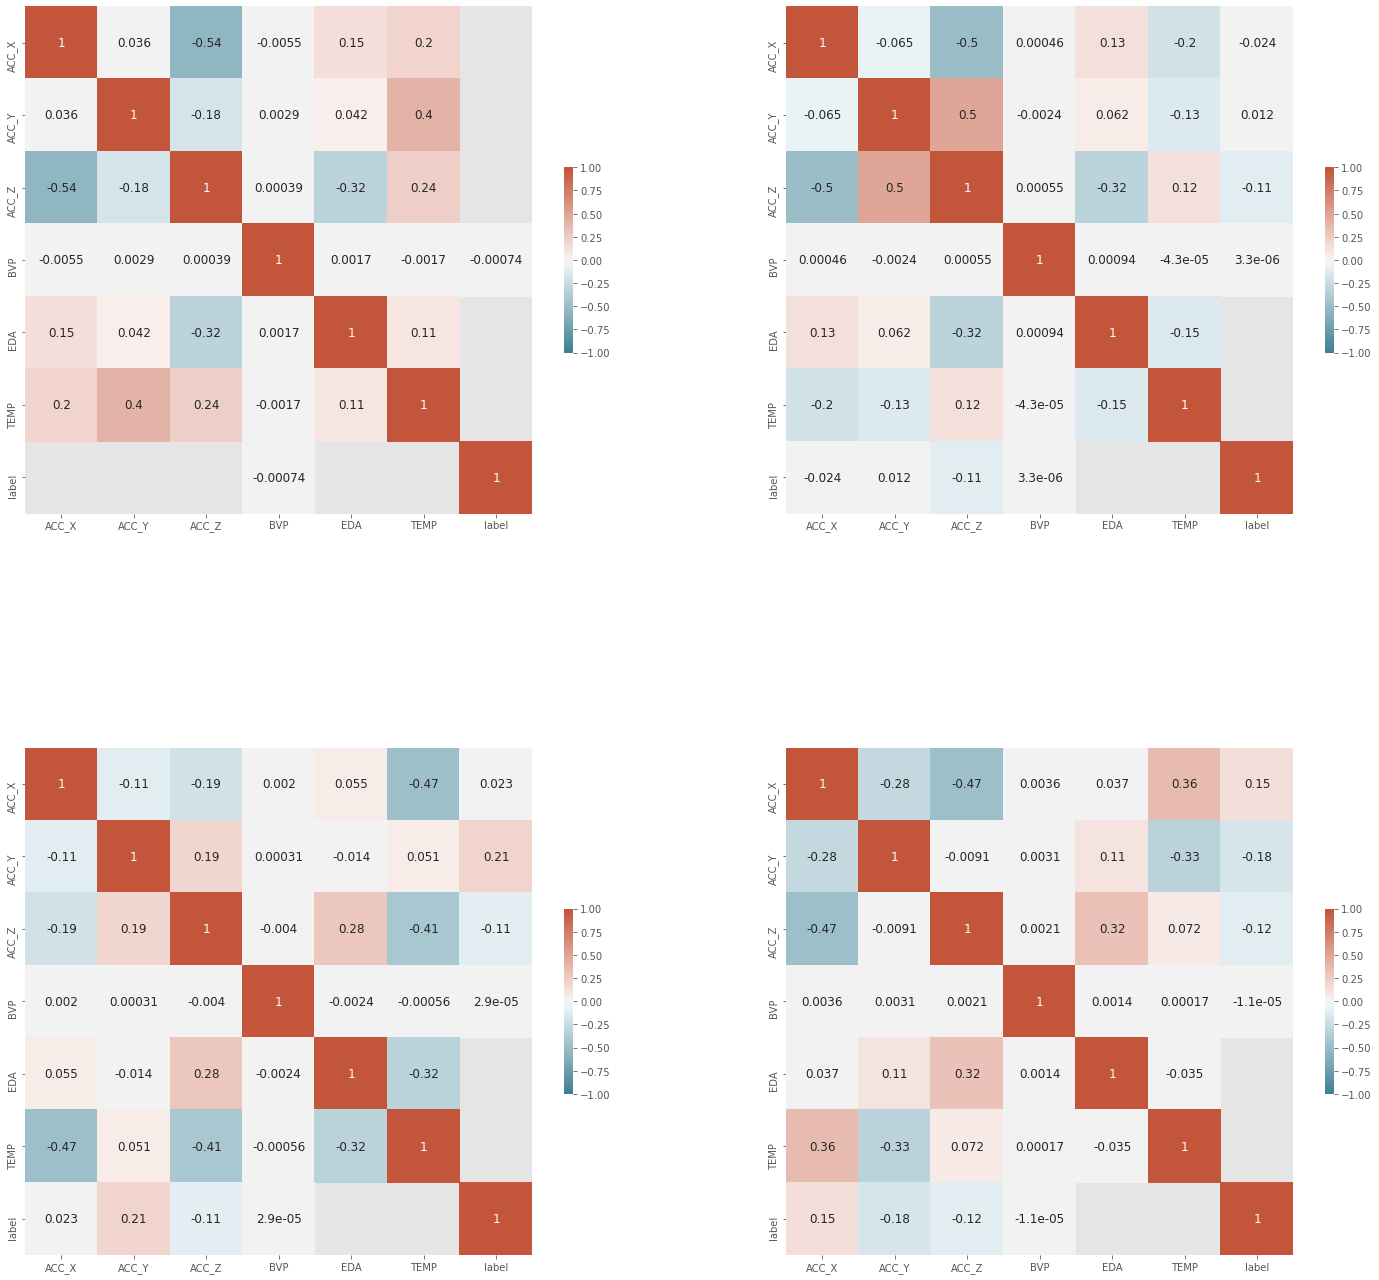

In [35]:
# Create a figure instance and 4 subplots
fig = plt.figure(figsize = (25,25)) # width x height
ax1 = fig.add_subplot(2, 2, 1) # row, column, position
ax2 = fig.add_subplot(2, 2, 2)
ax3 = fig.add_subplot(2, 2, 3)
ax4 = fig.add_subplot(2, 2, 4)

# Heatmap parameters
cmap = sns.diverging_palette(220, 20, n=200)
# We use ax parameter to tell seaborn which subplot to use for this plot
sns.heatmap(data=corr_dct['S6'], ax=ax1, cmap = cmap, vmin=-1, vmax=1, center=0, square=True, cbar_kws={'shrink': .3}, annot=True, annot_kws={'fontsize': 12})
sns.heatmap(data=corr_dct['S7'], ax=ax2, cmap = cmap, vmin=-1, vmax=1, center=0, square=True, cbar_kws={'shrink': .3}, annot=True, annot_kws={'fontsize': 12})
sns.heatmap(data=corr_dct['S8'], ax=ax3, cmap = cmap, vmin=-1, vmax=1, center=0, square=True, cbar_kws={'shrink': .3}, annot=True, annot_kws={'fontsize': 12})
sns.heatmap(data=corr_dct['S9'], ax=ax4, cmap = cmap, vmin=-1, vmax=1, center=0, square=True, cbar_kws={'shrink': .3}, annot=True, annot_kws={'fontsize': 12})

<AxesSubplot:>

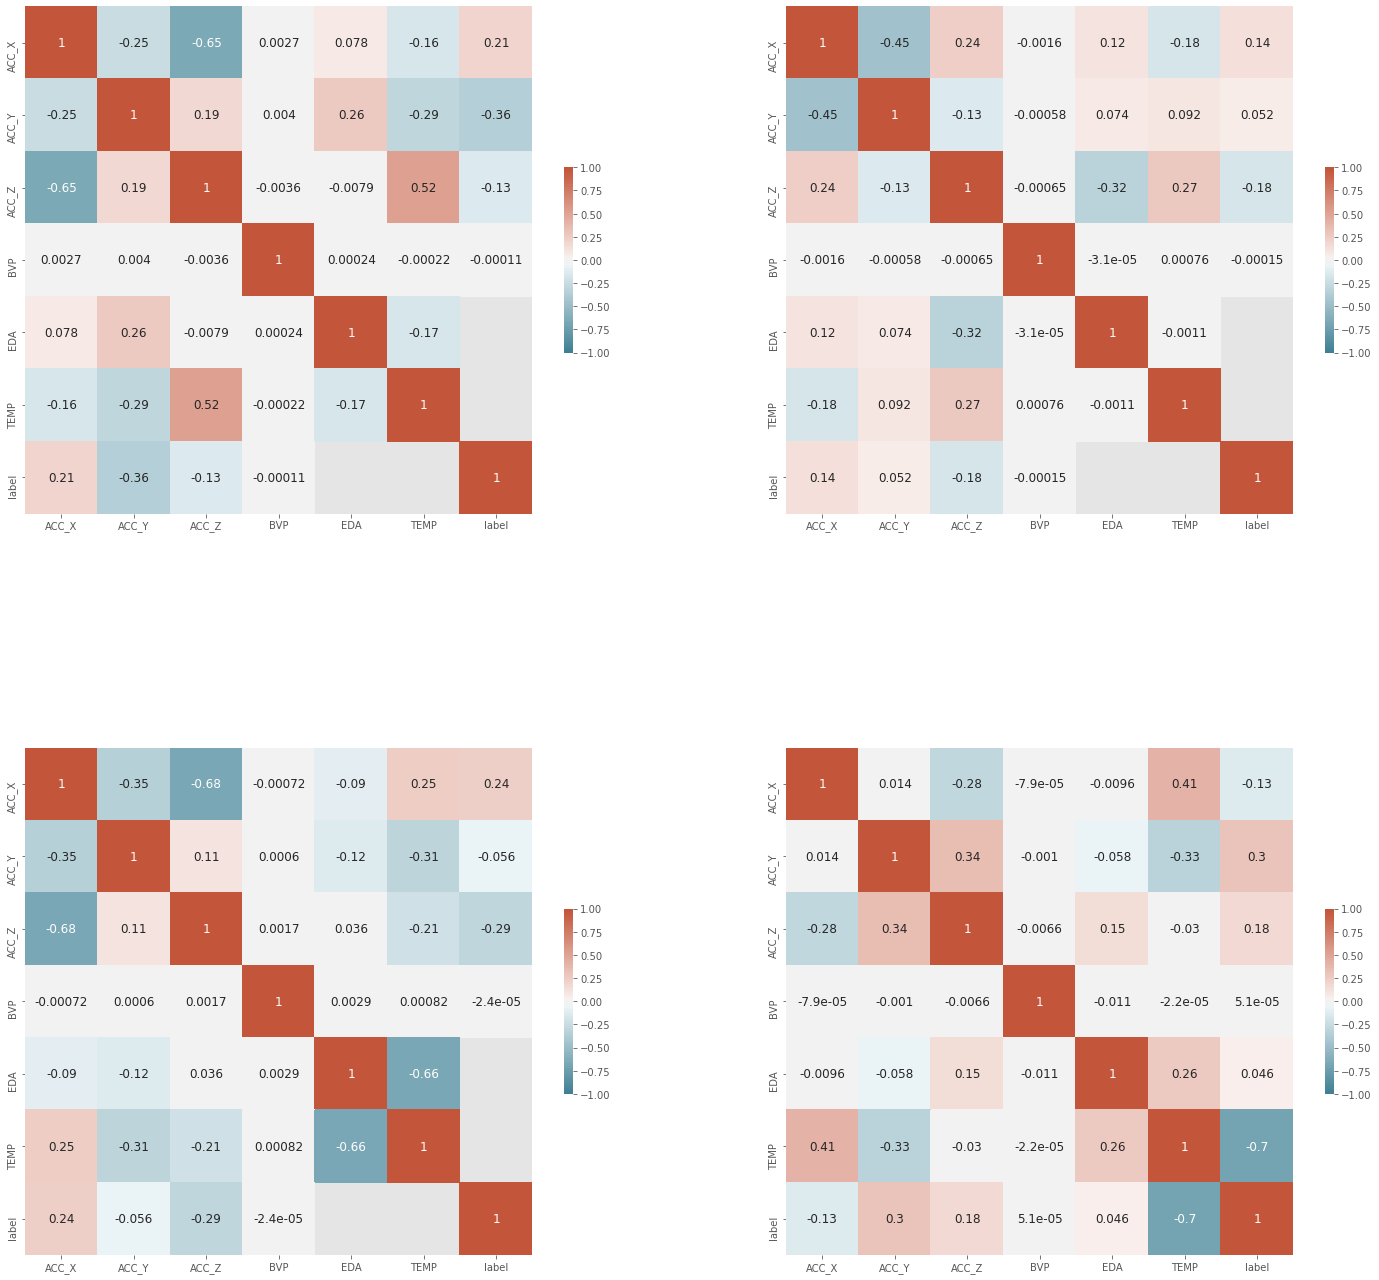

In [36]:
# Create a figure instance and 4 subplots
fig = plt.figure(figsize = (25,25)) # width x height
ax1 = fig.add_subplot(2, 2, 1) # row, column, position
ax2 = fig.add_subplot(2, 2, 2)
ax3 = fig.add_subplot(2, 2, 3)
ax4 = fig.add_subplot(2, 2, 4)

# Heatmap parameters
cmap = sns.diverging_palette(220, 20, n=200)
# We use ax parameter to tell seaborn which subplot to use for this plot
sns.heatmap(data=corr_dct['S10'], ax=ax1, cmap = cmap, vmin=-1, vmax=1, center=0, square=True, cbar_kws={'shrink': .3}, annot=True, annot_kws={'fontsize': 12})
sns.heatmap(data=corr_dct['S11'], ax=ax2, cmap = cmap, vmin=-1, vmax=1, center=0, square=True, cbar_kws={'shrink': .3}, annot=True, annot_kws={'fontsize': 12})
sns.heatmap(data=corr_dct['S13'], ax=ax3, cmap = cmap, vmin=-1, vmax=1, center=0, square=True, cbar_kws={'shrink': .3}, annot=True, annot_kws={'fontsize': 12})
sns.heatmap(data=corr_dct['S14'], ax=ax4, cmap = cmap, vmin=-1, vmax=1, center=0, square=True, cbar_kws={'shrink': .3}, annot=True, annot_kws={'fontsize': 12})

<AxesSubplot:>

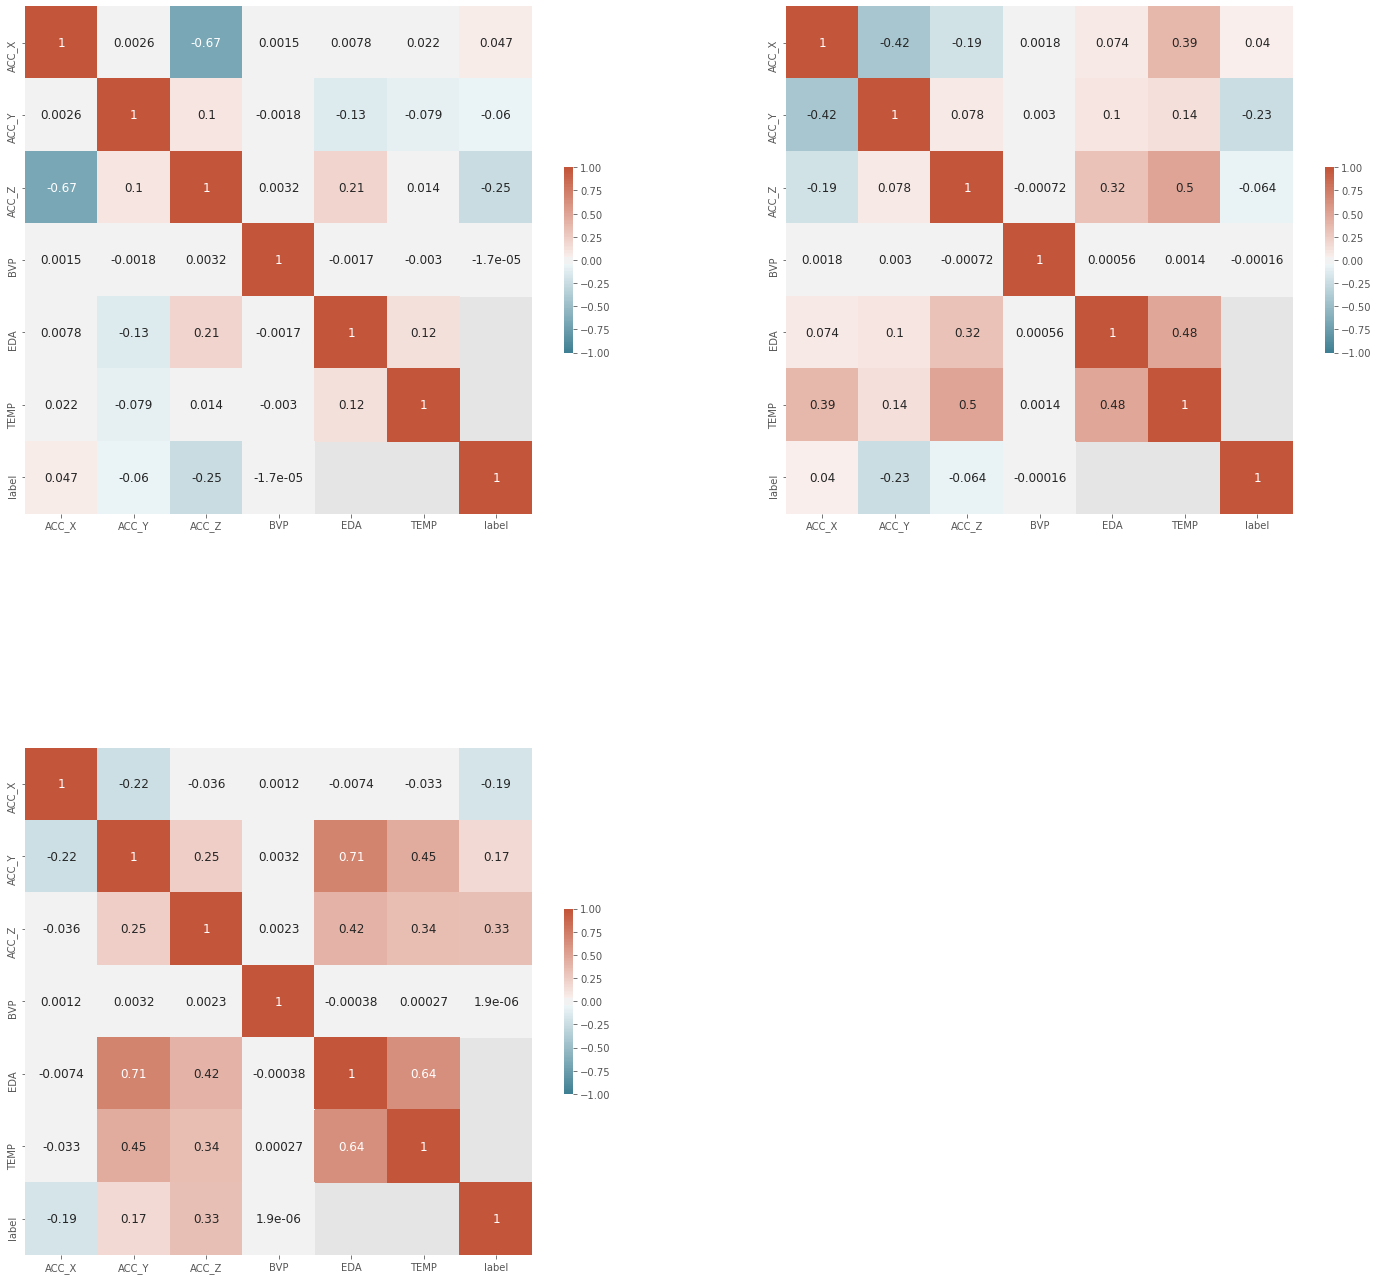

In [37]:
# Create a figure instance and 4 subplots
fig = plt.figure(figsize = (25,25)) # width x height
ax1 = fig.add_subplot(2, 2, 1) # row, column, position
ax2 = fig.add_subplot(2, 2, 2)
ax3 = fig.add_subplot(2, 2, 3)

# Heatmap parameters
cmap = sns.diverging_palette(220, 20, n=200)
# We use ax parameter to tell seaborn which subplot to use for this plot
sns.heatmap(data=corr_dct['S15'], ax=ax1, cmap = cmap, vmin=-1, vmax=1, center=0, square=True, cbar_kws={'shrink': .3}, annot=True, annot_kws={'fontsize': 12})
sns.heatmap(data=corr_dct['S16'], ax=ax2, cmap = cmap, vmin=-1, vmax=1, center=0, square=True, cbar_kws={'shrink': .3}, annot=True, annot_kws={'fontsize': 12})
sns.heatmap(data=corr_dct['S17'], ax=ax3, cmap = cmap, vmin=-1, vmax=1, center=0, square=True, cbar_kws={'shrink': .3}, annot=True, annot_kws={'fontsize': 12})

In [ ]:
# ACC label correlations
corr_dct = {}
combined_dct = {}
N = 175 # Validated by code above
for subject in subject_ids:
    
    # Calculate mean/median for chest data
    df = subject_dct[subject]['chest_df']['EDA']
    mean = pd.DataFrame(df.groupby(df.index // N).mean()).rename(columns={'EDA': 'EDA_CHEST_MEAN'})
    median = pd.DataFrame(df.groupby(df.index // N).median()).rename(columns={'EDA': 'EDA_CHEST_MEDIAN'})
    combined = pd.concat([mean,median],axis=1)
    combined_dct[subject] = combined
    
    # Calculate correlation with wrist data
    chest_df = subject_dct[subject]['wrist_dfs']['wrist_eda_df'].rename(columns={'EDA': 'EDA_WRIST'})
    all_data = pd.concat([chest_df,combined],axis=1)
    corr_dct[subject] = all_data.corr()

# Conclusions

TO BE FILLED IN